## TUTORIAL 01 - Thermal block problem
**_Keywords: certified reduced basis method, scalar problem_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional domain $\Omega$.

We define two subdomains $\Omega_1$ and $\Omega_2$, such that
1. $\Omega_1$ is a disk centered at the origin of radius $r_0=0.5$, and
2. $\Omega_2=\Omega/\ \overline{\Omega_1}$. 

The conductivity $\kappa$ is assumed to be constant on $\Omega_1$ and $\Omega_2$, i.e.
$$
\kappa|_{\Omega_1}=\kappa_0 \quad \textrm{and} \quad \kappa|_{\Omega_2}=1.
$$

For this problem, we consider $P=2$ parameters:
1. the first one is related to the conductivity in $\Omega_1$, i.e. $\mu_0\equiv k_0$ (_note that parameters numbering is zero-based_);
2. the second parameter $\mu_1$ takes into account the constant heat flux over $\Gamma_{base}$.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
on the parameter domain
$$
\mathbb{P}=[0.1,10]\times[-1,1].
$$

In this problem we model the heat transfer process due to the heat flux over the bottom boundary $\Gamma_{base}$ and the following conditions on the remaining boundaries:
* the left and right boundaries $\Gamma_{side}$ are insulated,
* the top boundary $\Gamma_{top}$ is kept at a reference temperature (say, zero),

with the aim of measuring the average temperature on $\Gamma_{base}$.

In order to obtain a faster evaluation (yet, provably accurate) of the output of interest we propose to use a certified reduced basis approximation for the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})$ such that

$$
\begin{cases}
	- \text{div} (\kappa(\mu_0)\nabla u(\boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
	u(\boldsymbol{\mu}) = 0 & \text{on } \Gamma_{top},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = 0 & \text{on } \Gamma_{side},\\
	\kappa(\mu_0)\nabla u(\boldsymbol{\mu})\cdot \mathbf{n} = \mu_1 & \text{on } \Gamma_{base}.
\end{cases}
$$
<br>

where 
* $\mathbf{n}$ denotes the outer normal to the boundaries $\Gamma_{side}$ and $\Gamma_{base}$,
* the conductivity $\kappa(\mu_0)$ is defined as follows:
$$
\kappa(\mu_0) =
\begin{cases}
	\mu_0 & \text{in } \Omega_1,\\
	1 & \text{in } \Omega_2,\\
\end{cases}
$$

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in H^1(\Omega) : v|_{\Gamma_{top}}=0\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u, v;\boldsymbol{\mu})=\int_{\Omega} \kappa(\mu_0)\nabla u\cdot \nabla v \ d\boldsymbol{x},$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v; \boldsymbol{\mu})= \mu_1\int_{\Gamma_{base}}v \ ds.$$

The (compliant) output of interest $s(\boldsymbol{\mu})$ given by
$$s(\boldsymbol{\mu}) = \mu_1\int_{\Gamma_{base}} u(\boldsymbol{\mu})$$
is computed for each $\boldsymbol{\mu}$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward:
$$a(u,v;\boldsymbol{\mu})=\underbrace{\mu_0}_{\Theta^{a}_0(\boldsymbol{\mu})}\underbrace{\int_{\Omega_1}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_0(u,v)} \ + \  \underbrace{1}_{\Theta^{a}_1(\boldsymbol{\mu})}\underbrace{\int_{\Omega_2}\nabla u \cdot \nabla v \ d\boldsymbol{x}}_{a_1(u,v)},$$
$$f(v; \boldsymbol{\mu}) = \underbrace{\mu_1}_{\Theta^{f}_0(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{base}}v \ ds}_{f_0(v)}.$$
We will implement the numerical discretization of the problem in the class
```
class ThermalBlock(EllipticCoerciveCompliantProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(u, v)$ and linear forms $f_*(v)$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ThermalBlock(EllipticCoerciveCompliantProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveCompliantProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)

    # Return custom problem name
    def name(self):
        return "ThermalBlock"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return min(self.compute_theta("a"))

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = mu[1]
            return (theta_f0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx(1)
            a1 = inner(grad(u), grad(v)) * dx(2)
            return (a0, a1)
        elif term == "f":
            ds = self.ds
            f0 = v * ds(1)
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/thermal_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/thermal_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/thermal_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ThermalBlock class

In [5]:
problem = ThermalBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(0.1, 10.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = PODGalerkin(problem)#ReducedBasis(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-10)#1e-5)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

### 4.5b Train the neural network

In [8]:
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

In [18]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, optimizer, 
    by_validation=True
)

In [19]:
pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, num_epochs=10000, starting_epoch=starting_epoch
)
pinn_trainer.train()

0 2.0041102935019977 	Loss(validation) = 1.7949527826286746
100 0.8098595254571604 	Loss(validation) = 0.8239539860065908
200 0.07376536451555935 	Loss(validation) = 0.11054340986463163
300 0.032506990791980994 	Loss(validation) = 0.05706714737119286
400 0.021400723282447277 	Loss(validation) = 0.03840178528375256
500 0.01582560738468853 	Loss(validation) = 0.027682743564351638
600 0.012717029758792544 	Loss(validation) = 0.020901920423737102
700 0.010625249141979962 	Loss(validation) = 0.01603458157755401
800 0.00899150693881031 	Loss(validation) = 0.012201710214556044
900 0.007610156124622518 	Loss(validation) = 0.009083760309660825
1000 0.006407948030737816 	Loss(validation) = 0.006577298585497593
1100 0.0053641707105077955 	Loss(validation) = 0.0046392427741934715
1200 0.004467743518955878 	Loss(validation) = 0.0032144947024169966
1300 0.0037052303823686774 	Loss(validation) = 0.002224340690422533
1400 0.0030637917018688345 	Loss(validation) = 0.001582774226474161
1500 0.0025323771

In [ ]:
fig, ax = Training.plot_loss(pinn_net)

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (8.0, -1.0), input_normalization_pinn, output_normalization_pinn
)

In [15]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, optimizer, 
    by_validation=True
)

In [16]:
pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000, starting_epoch=starting_epoch
)
pdnn_trainer.train()

0 1.1213296205498073 	Loss(validation) = 0.9281168327057925
100 0.31086133479936956 	Loss(validation) = 0.4616474151444268
200 0.02490030156411408 	Loss(validation) = 0.09691212773556565
300 0.009846360513376019 	Loss(validation) = 0.05836793379213525
400 0.004984163710644438 	Loss(validation) = 0.03773956109960729
500 0.003144209236175239 	Loss(validation) = 0.030493420968079093
600 0.002011793033329381 	Loss(validation) = 0.025605110460427814
700 0.001340365235292198 	Loss(validation) = 0.021524368573844425
800 0.0009436352743937481 	Loss(validation) = 0.018052556997248247
900 0.0007010564212842435 	Loss(validation) = 0.015272778532505998
1000 0.0005467755265220757 	Loss(validation) = 0.013126061553799185
1100 0.00044513133525907216 	Loss(validation) = 0.011477113719900314
1200 0.00037560181780620105 	Loss(validation) = 0.010196651806663546
1300 0.00032594253203211505 	Loss(validation) = 0.009187429151189377
1400 0.000288210907334858 	Loss(validation) = 0.0083810085066203
1500 0.0002

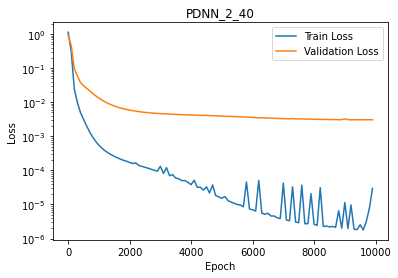

In [17]:
fig, ax = Training.plot_loss(pdnn_net)

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (8.0, -1.0), input_normalization_pdnn, output_normalization_pdnn
)

In [12]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, optimizer, 
    by_validation=True
)

In [13]:
prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=10000, starting_epoch=starting_epoch
)
prnn_trainer.train()

0 3.043749819205728 	Loss(validation) = 2.613498617633369
100 1.083758900185742 	Loss(validation) = 1.1660659733211267
200 0.1084410617263725 	Loss(validation) = 0.19592235193033136
300 0.07217814905281784 	Loss(validation) = 0.15839276293417281
400 0.046068585740646636 	Loss(validation) = 0.11604312143709163
500 0.030105140685326347 	Loss(validation) = 0.08456265308998145
600 0.021210449292125497 	Loss(validation) = 0.06439433204895598
700 0.0157041464996602 	Loss(validation) = 0.050424512517427855
800 0.011940387202018114 	Loss(validation) = 0.040133966835480234
900 0.009273594973299675 	Loss(validation) = 0.03230546880116514
1000 0.007350173993965564 	Loss(validation) = 0.026239292199317366
1100 0.005931587477932393 	Loss(validation) = 0.021485279457963555
1200 0.004858418031578122 	Loss(validation) = 0.01772374772734435
1300 0.0040273741240634195 	Loss(validation) = 0.014717838656961055
1400 0.003371047757787741 	Loss(validation) = 0.012292469832896639
1500 0.0028440271981103674 	L

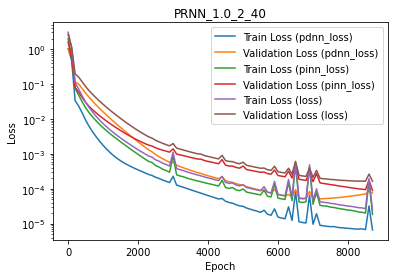

In [14]:
fig, ax = Training.plot_loss(prnn_net, separate=True)

In [21]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 4 #####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0007349936664470095	0.0007350077629167113	3.548215432614033e-07
mean	0.010864683935554047	0.010864683929593374	5.070341389591286e-07
max	0.3883096048903925	0.388309607645923	1.792591605054079e-06


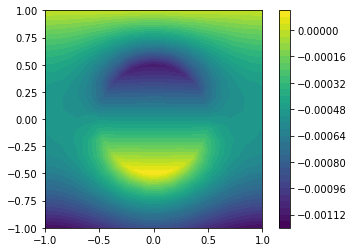

In [20]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (8.0, -1.0), input_normalization_prnn, output_normalization_prnn
)

In [22]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)

#####################################################################################
Mean Relative Error for 4 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.006571303897476325	0.006571304983211995	5.070341389591286e-07
pdnn_net	0.011598849886865978	0.011598850398900098	5.070341389591286e-07
prnn_net	0.010864683935554047	0.010864683929593374	5.070341389591286e-07
#####################################################################################


### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()